# Optimal Pricing Strategy

### The optimal price equation

For a given product with features $x$ (among them the cost $c$), let $f(x)$ be a pricing strategy. Let the demand at price $f$ of product $x$ be $D(x, f)$, which corresponds to the probability that the client purchases the product given the features $x$ and the set price $f$.

The expected revenue is $R = \mathbb E[f-c]$, where
$$\mathbb E[f-c] = \int dx (f(x)-c) D(x, f) P(x),$$
where $P(x)$ is the frequency with which a product with features $x$ is offered.

The optimal pricing must fullfill the optimality condition
$$
    \left.\frac{\delta \mathbb E[f-c]}{\delta f}\right|_{f=f^*} = \mathbb E\left[D(x, f^*) + (f^* - c)\left.\frac{\partial D}{\partial f}\right|_{f=f^*}\right] = 0
$$

where $\frac{\partial D}{\partial f}$ is the elasticity of the demand at price $f$.

This results in the **optimal price equation** for a given product with features $x$:
$$
    (f^*-c)\left.\frac{\partial D(x, f)}{\partial f}\right|_{f=f^*} + D(x, f^*) = 0
$$


This equation has no trivial solution and requires taiolerd numerical methods for each specific demand function $D(x, f)$

Since the optimal price equation is linear in $D$ we can replace the demand by its normalized value, i.e., the probability that a customer purchases the product at given features $x$ and set price $f$, $D(x, f) = P(\textrm{purchase}|x, f)$.

### Modelling demand with a logistic regression

For a logistic regression, this probability can be expressed as
$$
    D(x, f) = \frac{1}{1+\exp(-k^\top\cdot x - z - \gamma f)}
$$
where $x$ is the full set of features (excluding `bag_total_price`), $k$ are the associated model parameters and $z$ is the intercept.  

The elasticity then becomes
$$
    \frac{\partial D(x, f)}{\partial f} = D(x, f)(1-D(x, f))\gamma
$$
and the optimal price equation can be written as
$$
    (f^*(x)-c) (1-D(x, f^*(x)))\gamma + 1 = 0
$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.special import expit, logit
from matplotlib.colors import Normalize

from pricing.benchmark import Benchmark
from pricing.models.baseline import LogisticRegressor
from pricing.plots import prob_hist

cmap = plt.colormaps["rainbow"]

file_path = 'data/export.xlsx'
df = pd.read_excel(file_path)
df['Bag_Purchased'] = df['Bag_Purchased'].astype(bool)

# Define features and target variable
X = df.drop(['Bag_Purchased'], axis=1)
y = df['Bag_Purchased']

model = LogisticRegressor()

model.fit(X, y)

y_pred = model.pipeline.predict(X)

y_pred.mean(), model.model.intercept_[0]

(0.10917293233082707, -0.11124757412578447)

In [2]:
theta = pd.Series(model.model_coefficients())
intercept = model.model.intercept_ 

In [3]:
def price_utility_plot(data, ylabel):
    fig, ax = plt.subplots(figsize=(7, 3))
    plt.scatter(Z, data['price'], s=.1, color=cmap(data['demand']))
    ax.set_xlabel('Utility')
    ax.set_ylabel(ylabel)
    ax.plot(np.array([-1, 5]), -np.array([-1, 5])/gamma, 'k--', label='odds=1')
    ax.plot(np.array([-1, 5]), (logit(.25) - np.array([-1, 5]))/gamma, color = 'tab:gray', ls='--', label='odds=1/4')
    ax.set_title('Price vs utility')
    fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
    ax.set_xlim([-2, 4])
    ax.set_ylim([0, 150])
    ax.legend()
    fig.subplots_adjust(bottom=0.15)
    return fig

### Explore class imbalance

In [4]:
# Compute contrubutions from other features
X_transf = pd.DataFrame(
    model.pipeline.named_steps['preprocessor'].transform(X),
    columns = model.get_feature_names()
)
theta = pd.Series(model.model_coefficients())

# This is the full set of predictors, including the sell price
KX = X_transf.dot(theta).rename('kx') + intercept

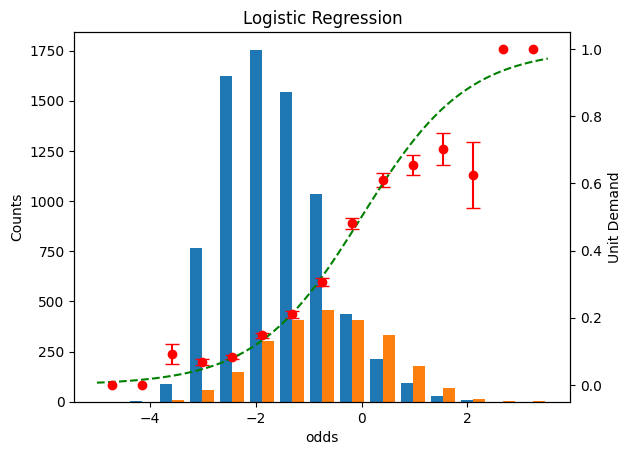

In [5]:
hist = prob_hist(
    predictor=KX,
    target=y,
    nbins=15
)
ax = hist.get_axes()

ax[0].set_title("Logistic Regression")
ax[1].set_ylabel("Unit Demand")
hist.savefig("images/odds.png")

In [6]:
# Sanity check: What's the predicted demand? (observed demand is 24%)
expit(KX).mean()

0.23680517219634659

### How well does the model predict the observed revenue?

In [7]:
actuals = pd.concat([X['bag_total_price'].rename('price'), y.rename('demand')], axis=1)

In [8]:
modeled = pd.DataFrame(dict(
    price = X['bag_total_price'].rename('optimal_price'),
    demand = expit(KX).rename('demand')
))

In [9]:
# Compute metrics for the model
cost = X['bag_base_price'].rename('cost')

results = pd.concat({
    "actuals": actuals, 
    "modeled": modeled
}, axis=1).astype(float)

def compute_extras(results):
    """
    Adds expecte revenue to dataframe
    """
    margin = results.xs('price', level=1, axis=1).add(-cost, axis='index')
    demand = results.xs('demand', level=1, axis=1)

    # Expected revenue
    exp_revenue = margin * demand

    # The Bernoulli variance
    variance = demand*(1 - demand)
    df = pd.concat(dict(
        exp_revenue = exp_revenue,
        variance = variance
    ), axis=1).reorder_levels([1, 0], axis=1)
    return pd.concat([results, df], axis=1)

def compute_summary(results):
    df = compute_extras(results).mean().unstack()
    styled = df.style\
        .format("{:.2f}")\
        .format('{:.2f}€', subset=["exp_revenue", "price"])\
        .format("{:.2%}", subset=['demand'])
    return styled

compute_summary(results)


,demand,exp_revenue,price,variance
actuals,23.90%,4.95€,64.62€,0.00
modeled,23.68%,4.80€,64.62€,0.15


The correctly model predicts the demand, expected revenue and average price

## Prepare the optimal price equation

Let's compute the contribution of all features, leaving aside the contribution from the total price. According to our model, the demand function is given by
$$
    D(x, f) = \textrm{expit}(Z + \gamma f)
$$
where we will call $Z=k^\top x + \textrm{intercept}$ **the utility**. 

The cost $c=$ `bag_base_price` should not be a part of the feature vector $x$. It is already filtered out by the pipeline in `X_transf`.

In [10]:
assert 'bag_base_price' not in theta.keys()

In [11]:
Z = (X_transf.drop('bag_total_price', axis=1).dot(theta.drop('bag_total_price')) + intercept).rename('kx')
gamma = theta['bag_total_price']

gamma

-0.028836335530569437

As expected the elasticity is negative, more price translates to lower demand

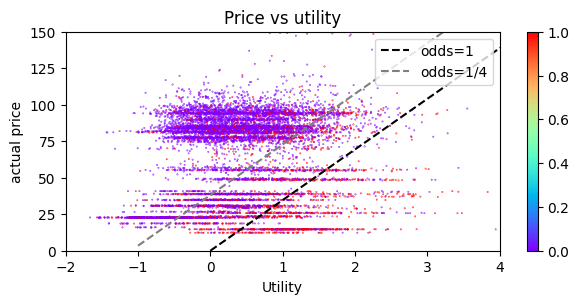

In [12]:
fig = price_utility_plot(actuals.astype(float), ylabel='actual price')
fig.savefig("images/price_vs_utility.png")

In [13]:
def optimal_price_equation(f, c, z, g):
    return g * (f - c) * (1 - expit(z + g * f)) + 1
    
def optimize(cost, Z):
    return fsolve(optimal_price_equation, x0=1.5 * cost, args=(cost, Z, gamma))[0]

In [14]:
price = pd.concat([cost, Z], axis=1).apply(
        lambda row: optimize(row['cost'], row['kx']),
    axis=1).rename('price')
prob = expit(Z + gamma * price)
optimal = pd.DataFrame({"price": price, "demand": prob})


results = pd.concat({
    "actuals": actuals, 
    "modeled": modeled,
    "optimal": optimal
}, axis=1).astype(float)

results.sample(10)

actuals            modeled              optimal          
           price demand       price    demand      price    demand
4389   92.905006    1.0   92.905006  0.181999  96.320484  0.167793
7911   23.035002    0.0   23.035002  0.266418  53.465449  0.131202
652   100.249008    0.0  100.249008  0.110320  98.209129  0.116227
5525   38.998001    0.0   38.998001  0.258206  63.562857  0.146331
9083   94.519997    0.0   94.519997  0.155788  96.349131  0.148976
436    85.561005    1.0   85.561005  0.116950  89.149714  0.106679
8283   88.026001    0.0   88.026001  0.079364  89.337050  0.076646
4875   75.378006    0.0   75.378006  0.135888  83.351720  0.111076
7780   93.755005    0.0   93.755005  0.041137  91.419886  0.043877
1482   90.406006    0.0   90.406006  0.104898  91.766175  0.101272

### Explore results

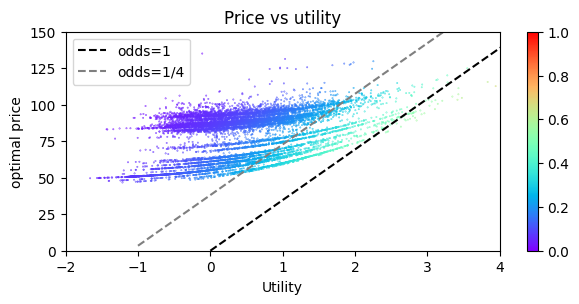

In [15]:
# Look at the price-utility trend
fig = price_utility_plot(optimal, ylabel='optimal price')
fig.savefig("images/optimal_vs_utility.png")

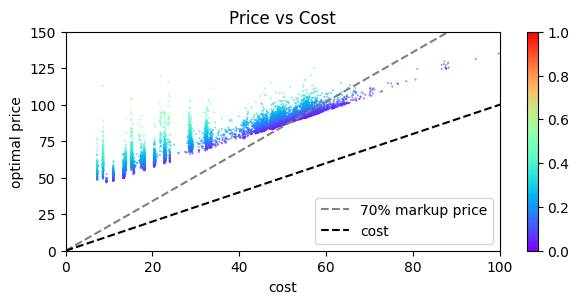

In [16]:
def price_cost_plot(data, ylabel):
    fig, ax = plt.subplots(figsize=[7, 3])
    ax.scatter(cost, data['price'], s=.1, color=cmap(data['demand']))
    ax.set_xlabel('cost')
    ax.set_ylabel(ylabel)
    line = np.array([0, 150])
    ax.plot(line, 1.7 * line, c='gray', ls='--', label='70% markup price')
    ax.plot(line, line, 'k--', label='cost')
    fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
    
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 150])
    ax.set_title("Price vs Cost")
    ax.legend()
    fig.subplots_adjust(bottom=0.15)
    
    return fig
fig = price_cost_plot(optimal, ylabel='optimal price')
fig.savefig("images/optimal_vs_cost.png")

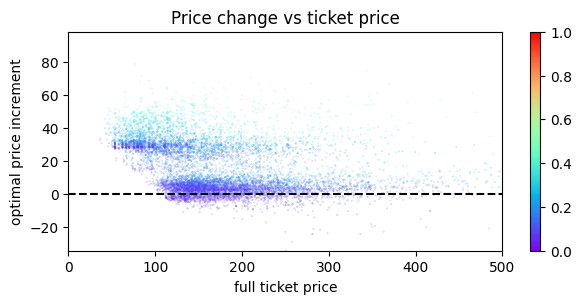

In [17]:
def price_change_plot(data, model):
    fig, ax = plt.subplots(figsize=[7, 3])
    
    x = X['price'] + X['bag_total_price']
    y = X['price'] + data['price'] - x
    ax.scatter(x, y, label='demand', s=.01, c=cmap(data['demand']))
    # ax.scatter(x[~y], results['price'][~y] + results['optimal_price'][~y] - x[~y], label='not purchased', s=.01)
    ax.set_xlabel('full ticket price')
    ax.set_ylabel(f'{model} price increment')
    ax.plot([0, 600], [0, 0], 'k--')
    ax.set_xlim([0, 500])

    ymax = y.max()
    ymin = y.min()
    ax.set_ylim([ymin, ymax])
    fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
    ax.set_title("Price change vs ticket price")
    fig.subplots_adjust(bottom=0.15)
    return fig

fig = price_change_plot(optimal, model='optimal')
fig.savefig("images/optimal_change.png")

In [18]:
compute_summary(results)

,demand,exp_revenue,price,variance
actuals,23.90%,4.95€,64.62€,0.00
modeled,23.68%,4.80€,64.62€,0.15
optimal,15.59%,7.03€,79.72€,0.12


**We see that the total number of bags purchased would drop from 24% to 15%. Perhaps this is unacceptable**

## Constrained optimization formulation


We need to maximize the profit subject to keeping the demand above a certain threshold

$$
\begin{align}
    & \textrm{maximize}_{f(x)} & &\mathbb{E}\left[(f(x) - c) D(x, f(x)\right]\\
    & \textrm{subject~to} & & \mathbb{E}\left[D(x, f(x))\right] > k
\end{align}
$$

We'll use a soft constraint for this optimization
$$
\begin{align}
    L[f] = \mathbb{E}\left[(c-f(x) - \lambda) D(x, f(x)\right] + e^{\lambda(k - \mathbb{E}[D(x, f(x)])}
\end{align}
$$


In [19]:
# Set the target demand as the current
k = y.mean()

# Set a strong penalty
lamb = 100

In [20]:
import numpy as np
from scipy.optimize import minimize


In [21]:
# Define the Lagrangian

# Function to be minimized
def L(f):
    # The array of probabilities
    prob = expit(Z + gamma * f(Z, cost))

    # The constraint. Should be negative
    constraint = (k - prob.mean()) 

    # The objective function with an exponential penalty
    out = ((cost - f(Z, cost)) * prob).mean() + np.exp(lamb * constraint)
    return out

# Define a quadratic function f(z, cost)
def func(z, cost, a, b, c, d, e, f):
    return a*z**2 + b * z * cost + c * cost** 2 + d * z + e * cost + f

# Define the objective
def objective(params):
    a, b, c, d, e, f = params
    return L(lambda z, cost: func(z, cost, a, b, c, d, e, f))

# Initial guess for the parameters a, b, c, d, e, f
initial_guess = [1/np.power(Z, 2).mean(), 1/(Z * cost).mean(), 1/np.power(cost, 2).mean(), 1/Z.mean(), 1/cost.mean(), .1]

# Call the minimize function
res = minimize(objective, initial_guess, method='Nelder-Mead')

# Use this result as a starting point for a new iteration
res = minimize(objective, res.x)

In [22]:
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -5.2945930151773455
        x: [ 2.327e+00 -1.354e-01  1.972e-03  1.173e+01  6.607e-01
             2.337e+01]
      nit: 41
      jac: [ 1.907e-06  3.082e-05  2.117e-03  7.749e-07  4.750e-05
             1.550e-06]
 hess_inv: [[ 1.570e+02 -9.620e-01 ...  1.565e+00 -2.536e+01]
            [-9.620e-01  7.408e-01 ... -1.888e-01  1.048e+01]
            ...
            [ 1.565e+00 -1.888e-01 ...  1.269e+01 -1.679e+02]
            [-2.536e+01  1.048e+01 ... -1.679e+02  2.566e+03]]
     nfev: 655
     njev: 92

In [23]:
F = lambda z, cost: func(z, cost, *res.x)

In [24]:
price = F(Z, cost).rename('price')
demand = expit(Z + gamma * price).rename('demand')
constrained = pd.concat([price, demand], axis=1)
constrained.head()

,price,demand
0,28.979015,0.133824
1,67.910797,0.112102
2,50.240156,0.222097
3,25.573354,0.164492
4,65.685203,0.297417


In [25]:
results = pd.concat(dict(
    actuals = actuals,
    modeled = modeled,
    optimal = optimal,
    constrained = constrained
), axis=1)

compute_summary(results)

,demand,exp_revenue,price,variance
actuals,23.90%,4.95€,64.62€,0.00
modeled,23.68%,4.80€,64.62€,0.15
optimal,15.59%,7.03€,79.72€,0.12
constrained,25.13%,5.59€,56.45€,0.18


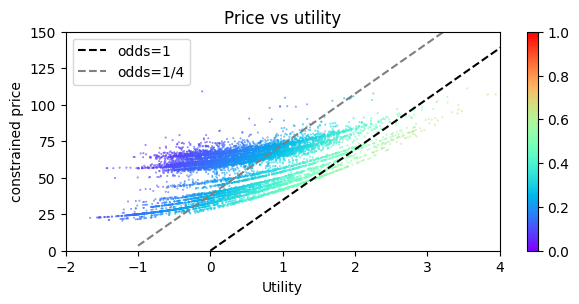

In [26]:
fig = price_utility_plot(constrained, ylabel='constrained price')
fig.savefig("images/constrained_utility.png")

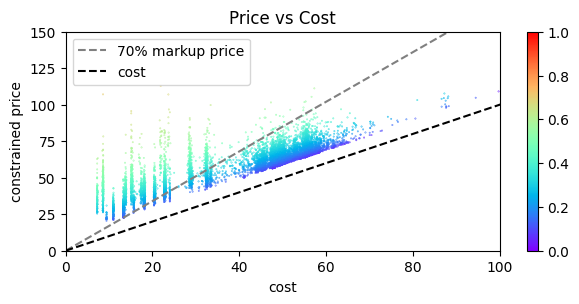

In [27]:
fig = price_cost_plot(constrained, ylabel='constrained price')
fig.savefig("images/constrained_cost.png")

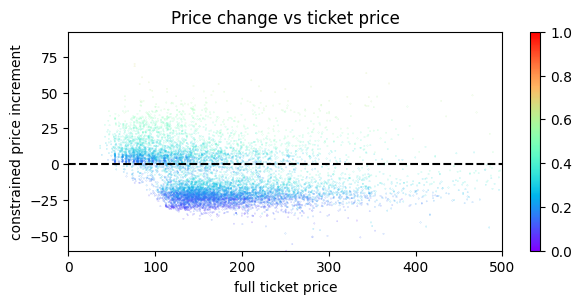

In [28]:
fig = price_change_plot(constrained, model='constrained')
fig.savefig("images/constrained_change.png")

In [29]:
(constrained['price']/cost - 1).describe()

count    9975.000000
mean        0.793885
std         0.945753
min         0.093935
25%         0.251845
50%         0.396504
75%         0.979201
max        11.439885
dtype: float64

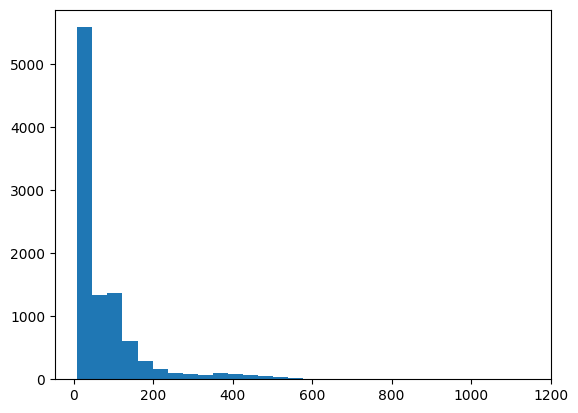

In [30]:
fig = (100*(constrained['price']/cost - 1)).hist(bins=30)
fig.grid(False)

## Risk analysis: Volatility 

In [31]:
compute_summary(results)

,demand,exp_revenue,price,variance
actuals,23.90%,4.95€,64.62€,0.00
modeled,23.68%,4.80€,64.62€,0.15
optimal,15.59%,7.03€,79.72€,0.12
constrained,25.13%,5.59€,56.45€,0.18


In [32]:
# Let's compute the expected fluctuations for each model

# Enrich results with extra metrics
rich_results = compute_extras(results)

summary = {}

for model in rich_results.columns.get_level_values(level=0).unique():
    res = rich_results.xs(model, level=0, axis=1)

    mean = res.mean()
    mean['std'] = np.sqrt(mean['variance'])

    print(f"\nVariance for model {model}\n========================")
    print(f"Expected revenue per flight is going to be {mean['exp_revenue']:.2f}€ +/- {mean['std']:.2f}€")
    print(f"Total expected revenue in the period is going to be {mean['exp_revenue']*len(res):.0f}€ +/- {mean['std']*len(res):.0f}€")
    print(f"68% (1-sigma) Confidence interval is [{(mean['exp_revenue'] - mean['std'])*len(res):.0f}€, {(mean['exp_revenue'] + mean['std'])*len(res):.0f}€]")
    print(f"95% (2-sigma) Confidence interval is [{(mean['exp_revenue'] - 2*mean['std'])*len(res):.0f}€, {(mean['exp_revenue'] + 2*mean['std'])*len(res):.0f}€]")

    summary[model] = mean

summary = pd.concat(summary, axis=1)

summary


Variance for model actuals
Expected revenue per flight is going to be 4.95€ +/- 0.00€
Total expected revenue in the period is going to be 49376€ +/- 0€
68% (1-sigma) Confidence interval is [49376€, 49376€]
95% (2-sigma) Confidence interval is [49376€, 49376€]

Variance for model modeled
Expected revenue per flight is going to be 4.80€ +/- 0.38€
Total expected revenue in the period is going to be 47899€ +/- 3832€
68% (1-sigma) Confidence interval is [44066€, 51731€]
95% (2-sigma) Confidence interval is [40234€, 55564€]

Variance for model optimal
Expected revenue per flight is going to be 7.03€ +/- 0.35€
Total expected revenue in the period is going to be 70171€ +/- 3495€
68% (1-sigma) Confidence interval is [66676€, 73666€]
95% (2-sigma) Confidence interval is [63182€, 77160€]

Variance for model constrained
Expected revenue per flight is going to be 5.59€ +/- 0.42€
Total expected revenue in the period is going to be 55722€ +/- 4180€
68% (1-sigma) Confidence interval is [51541€, 59902

,actuals,modeled,optimal,constrained
price,64.616167,64.616167,79.722653,56.448743
demand,0.238997,0.236805,0.155864,0.251324
exp_revenue,4.949967,4.801861,7.034674,5.586121
variance,0.000000,0.147616,0.122740,0.175623
std,0.000000,0.384208,0.350343,0.419074


### Use bootstrap to confirm volatility estimates

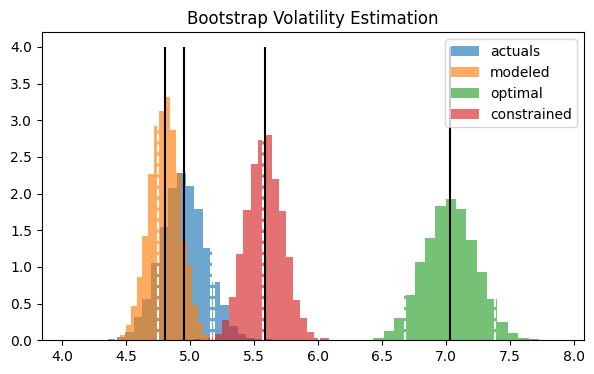

In [33]:
N = 5000
model = 'actuals'

def bootstrap_revenue(results):
    rev = []
    for i in range(N):
        sample = results.sample(len(results), replace=True)                            
        purchased = sample['demand'] > np.random.sample(sample.shape[0])
        revenue = (sample['price'] - cost) * purchased
        rev.append(revenue.mean())
    return pd.Series(rev)


rev = {}

for model in rich_results.columns.get_level_values(level=0).unique():
    rev[model] = bootstrap_revenue(results.xs(model, level=0, axis=1))

ymax = 4
df = pd.concat(rev, names=['model']).reset_index()
fig, ax = plt.subplots(figsize=[7, 4])

for g in pd.unique(df['model']):
    p = df.loc[df['model']==g, 0].hist(bins=20,
                                   alpha=0.65,
                                   label=g,
                                   density=True)
    c = p.get_facecolor()
    plt.vlines(summary.loc['exp_revenue', g], ymin=0, ymax=ymax, colors='black')
    if g == 'actuals':
        # Don't plot sigmas
        continue
        
    plt.vlines((summary.loc['exp_revenue', g] + summary.loc['std', g]), ymin=0, ymax=ymax, colors=c, linestyles='--')
    plt.vlines((summary.loc['exp_revenue', g] - summary.loc['std', g]), ymin=0, ymax=ymax, colors=c, linestyles='--')
    plt.vlines((summary.loc['exp_revenue', g] + 2 * summary.loc['std', g]), ymin=0, ymax=ymax, colors=c, linestyles='--')
    plt.vlines((summary.loc['exp_revenue', g] - 2 * summary.loc['std', g]), ymin=0, ymax=ymax, colors=c, linestyles='--')

    
plt.grid(False)
plt.legend(loc='upper right')
plt.title("Bootstrap Volatility Estimation")
fig.savefig("images/revenue_histograms.png")
